# AST model solution

In [1]:
import os.path as path
import os
import pickle
from enum import Enum
from typing import NoReturn, Optional
from tqdm import tqdm
import random
from pprint import pprint
import pandas as pd
import numpy as np
import time

import librosa
import librosa.feature as audio_F

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as nn_F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T

from transformers import ASTFeatureExtractor
from transformers import AutoModelForAudioClassification

import matplotlib.pyplot as plt

from IPython.display import Audio

import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.empty_cache()

In [3]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

cpu_count = os.cpu_count()
num_workers = cpu_count if device == "cpu" else 0
print(f'{num_workers=}, {cpu_count=}')

def set_random_state(random_state:int=0) -> NoReturn:
    """Initialize random generators.

    Parameters
    ==========
    random_state : int = 0
        Determines random number generation for centroid initialization.
        Use an int to make the randomness deterministic.
    """
    torch.manual_seed(random_state)
    random.seed(random_state)
    np.random.seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_state)
        torch.cuda.manual_seed(random_state)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return

random_state = 42
set_random_state(random_state)
torch.use_deterministic_algorithms(True)

%env CUBLAS_WORKSPACE_CONFIG=:4096:8
%env PYTHONHASHSEED=42

device='cuda'
num_workers=0, cpu_count=4
env: CUBLAS_WORKSPACE_CONFIG=:4096:8
env: PYTHONHASHSEED=42


In [4]:
base_folder = "/home/ext-zorkina-a@ad.speechpro.com/ZorkinaAnastasia/audio_analytics/kaggle"
train_folder = path.join(base_folder, "data/audio_train/train")
train_csv = path.join(base_folder, "data/train.csv")
train_pickle = path.join(base_folder, "data/train16k.pickle")
labels_pickle = path.join(base_folder, "data/labels16k.pickle")
test_folder = path.join(base_folder, "data/audio_test/test")
test_pickle = path.join(base_folder, "data/test16k.pickle")
test_csv = path.join(base_folder, "data/sample_submission.csv")
test_labels_pickle = path.join(base_folder, "data/test_labels16k.pickle")

## Предобработка данных с помощью ASTFeatureExtractor()

We can prepare the audio using ASTFeatureExtractor, which turns it into a tensor of shape (batch_size, time_dimension, frequency_dimension).  

ASTFeatureExtractor использует ta_kaldi.fbank, которая возвращает фичи - мел-спектрограммы, нормальзует их (в качсетве параметров нормализации используются значения mean и std с AudioSet) и дополняет/обрезает до заданной длины. 

In [5]:
from transformers import ASTFeatureExtractor

feature_extractor = ASTFeatureExtractor()

In [6]:
class SetType(Enum):
    """Set type"""
    TRAIN = 1
    TEST  = 2
    DEV   = 3


def extract_feats(set_type:SetType, path_to_csv:str, path_to_files:str,
                          out_path:str, labels_pickle:str):
   
    if set_type not in [SetType.TRAIN, SetType.TEST]:
        raise Exception(f'Such set type not supported: {set_type}')

    feats = []

    if set_type == SetType.TRAIN:
        meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label'])

        file_names = list(meta['fname'])
        n_files = len(file_names)
        labels = list(meta['label'])

        uniq_labels = np.sort(np.unique(labels))
        label_to_id = {label: i for i, label in enumerate(uniq_labels)}

        print('Total files:', n_files)

        for i, (file_name, label) in tqdm(enumerate(zip(file_names, labels))):
            waveform, sampling_rate = torchaudio.load(os.path.join(train_folder, file_name))
            waveform = waveform.squeeze().numpy()
            inputs = feature_extractor(waveform, sampling_rate=sampling_rate, padding="max_length", return_tensors="pt")
            input_values = inputs.input_values
            feats.append({
                'fname': file_name,
                'feature': input_values,
                'label_id': label_to_id[label]
            })

        pickle.dump(feats, open(out_path, 'wb'))
        pickle.dump(label_to_id, open(labels_pickle, 'wb'))
        return label_to_id
    else:
        for i, file_name in tqdm(enumerate(os.listdir(path_to_files))):
            waveform, sampling_rate = torchaudio.load(os.path.join(test_folder, file_name))
            waveform = waveform.squeeze().numpy()
            inputs = feature_extractor(waveform, sampling_rate=sampling_rate, padding="max_length", return_tensors="pt")
            input_values = inputs.input_values
            feats.append({
                'fname': file_name,
                'feature': input_values,
            })

        pickle.dump(feats, open(out_path, 'wb'))
        return

In [7]:
# extract train features and store to `train_pickle` extracted features
label_to_id = extract_feats(
    SetType.TRAIN,
    train_csv, 
    train_folder, 
    train_pickle,
    labels_pickle
)

id_to_label = [label for label, i in label_to_id.items()]

Total files: 5683


5683it [02:04, 45.71it/s]


In [114]:
# extract test features and store to `test_pickle` extracted features
extract_feats(
    SetType.TEST,
    test_csv, 
    test_folder, 
    test_pickle,
    test_labels_pickle
)

3790it [01:37, 38.87it/s]


Загрузим полученные данные и подготовим их для обучения

In [7]:
test_data = pickle.load(open(test_pickle, "rb"))
train_data = pickle.load(open(train_pickle, "rb"))
label_to_id = pickle.load(open(labels_pickle, "rb"))
id_to_label = [label for label, i in label_to_id.items()]

In [9]:
train_data[100]['feature'].shape

torch.Size([1, 1024, 128])

In [10]:
x = []
y = []

for i, row in enumerate(train_data):
        x.append(row['feature'])
        y.append(row['label_id'])

x_tr, x_val, y_tr, y_val = train_test_split(x, y, test_size=800, random_state=random_state, stratify=y)

In [11]:
x_test = []

for i, row in enumerate(test_data):
    feature = row['feature']
    x_test.append(feature)

In [13]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None, device="cpu"):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # добавить сюда prepare_shape()
        
        if self.y is not None:
            return \
                torch.tensor(self.x[idx], device=device).squeeze(),\
                torch.tensor(self.y[idx], device=device).squeeze()

        return torch.tensor(self.x[idx], device=device).squeeze()

In [14]:
train_dset = EventDetectionDataset(x_tr, y_tr, device=device)
val_dset = EventDetectionDataset(x_val, y_val, device=device)

In [42]:
train_loader = DataLoader(train_dset, batch_size=30, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=30, shuffle=False, num_workers=num_workers)

## Загрузка модели

Загружаем предобученную модель с помощью библиотеки transformers от Hugging Face. Использумеая версия модели "ast-finetuned-audioset-10-10-0.4593". Модель была загружена локально, для загрузки с HuggingFace использовать 
ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [43]:
from transformers import ASTFeatureExtractor
from transformers import AutoModelForAudioClassification

In [44]:
model_checkpoint = path.join(base_folder, "ast-finetuned-audioset-10-10-0.4593")
num_labels = len(id_to_label)
AST_model = AutoModelForAudioClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    label2id=label_to_id,
    id2label=id_to_label,
    ignore_mismatched_sizes=True)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at /home/ext-zorkina-a@ad.speechpro.com/ZorkinaAnastasia/audio_analytics/kaggle/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([41, 768]) in the model instantiated
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([41]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Посмотрим на структуру модели

In [45]:
AST_model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

Чтобы дообучить модель на нашу задачу, заменим последний слой классификатора ASTMLPHead. 

In [212]:
AST_model.classifier = nn.Sequential(
    nn.Linear(768, 128),
    nn.ReLU(),
    nn.Linear(128, 41)
)

In [72]:
#вариант со сверточным слоем
AST_model.classifier = nn.Sequential(
    nn.Unflatten(1, (1,768)),
    nn.Conv1d(1,  10, kernel_size=5, stride=2, device=device),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(3820, 41),
)

In [73]:
# для правильного сохранения модели
AST_model.config.id2label = {id: label for id, label in enumerate(id_to_label)}

In [74]:
# AST_model.config.max_length = 256

Заморозим все слои кроме классификатора и перенесем модель на gpu

In [75]:
AST_model.requires_grad_(False)
AST_model.classifier.requires_grad_(True)

Sequential(
  (0): Unflatten(dim=1, unflattened_size=(1, 768))
  (1): Conv1d(1, 10, kernel_size=(5,), stride=(2,))
  (2): ReLU()
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=3820, out_features=41, bias=True)
)

In [76]:
AST_model = AST_model.to(device)

In [22]:
for name, param in AST_model.named_parameters():
     print(name, param.requires_grad)

audio_spectrogram_transformer.embeddings.cls_token False
audio_spectrogram_transformer.embeddings.distillation_token False
audio_spectrogram_transformer.embeddings.position_embeddings False
audio_spectrogram_transformer.embeddings.patch_embeddings.projection.weight False
audio_spectrogram_transformer.embeddings.patch_embeddings.projection.bias False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.query.weight False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.query.bias False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.key.weight False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.key.bias False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.value.weight False
audio_spectrogram_transformer.encoder.layer.0.attention.attention.value.bias False
audio_spectrogram_transformer.encoder.layer.0.attention.output.dense.weight False
audio_spectrogram_transformer.encoder.layer.0.attention.output.den

## Дообучение модели на наших данных

In [89]:
from tqdm import tqdm
from tqdm.notebook import trange
import torch.optim as optim

optimizer = optim.AdamW(AST_model.parameters(), lr=5e-4)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15], gamma=0.5)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)



train_loss = []
val_loss = []

train_f1 = []
val_f1 = []



for epoch in tqdm(range(num_epochs), position=0, leave=True):
    
    AST_model.train()
    
    print(f'epoch #{epoch+1}')
    loss_list = []
    outputs = []
    targets = []
    
    for i_batch, sample_batched in enumerate(tqdm(train_loader, position=0, leave=True)):
        x, y = sample_batched

        output = AST_model(x, labels = y)
        outputs.append(output.logits.argmax(-1))

        target = y
        targets.append(target)
        
        loss = output.loss
        loss_list.append(loss.item())
        
        loss.backward()

        optimizer.step()
        #scheduler.step()
        optimizer.zero_grad()

        
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)

    f1 = f1_score(y_true, y_pred, average='macro')

    train_loss.append(np.mean(loss_list))
    train_f1.append(f1)

    print(f'[train] mean loss: {train_loss[-1]}')
    print(f'[train] f1:  {f1}')
    
    AST_model.eval()
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(tqdm(val_loader, position=0, leave=True)):
            x, y = sample_batched
            #optimizer.zero_grad()

            output = AST_model(x, labels = y)
            outputs.append(output.logits.argmax(-1))


            target = y
            targets.append(target)

            loss = output.loss
            loss_list.append(loss.item())


        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        f1 = f1_score(y_true, y_pred, average='macro')

            
        val_loss.append(np.mean(loss_list))
        val_f1.append(f1)
        
        best_val_f1 = max(val_f1)
        #if f1 >= best_val_f1:
            #print(f'model was saved, epoch #{epoch+1}')
            #AST_model.save_pretrained("best_model_weights", from_pt=True)
        
        print(f'[val] mean loss:   {val_loss[-1]}')
        print(f'[val] f1:    {f1}', end="\n\n")
        
        

    
#AST_model.save_pretrained("final_model_weights", from_pt=True)

  0%|          | 0/2 [00:00<?, ?it/s]

epoch #22


100%|██████████| 163/163 [07:40<00:00,  2.82s/it]


[train] mean loss: 0.034494563501522496
[train] f1:  0.9910690394710716


100%|██████████| 27/27 [01:15<00:00,  2.78s/it]


model was saved, epoch #1


 50%|█████     | 1/2 [08:58<08:58, 538.56s/it]

[val] mean loss:   0.6721315872338083
[val] f1:    0.8557114187634538

epoch #23


100%|██████████| 163/163 [07:41<00:00,  2.83s/it]


[train] mean loss: 0.018890754052614964
[train] f1:  0.9959113445457316


100%|██████████| 2/2 [17:55<00:00, 537.64s/it]


[val] mean loss:   0.7527912157001319
[val] f1:    0.8484320323105695



In [174]:
def plot_curves():
    
    epochs = range(1, num_epochs+1)

    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

    xticks = range(1, num_epochs+1, num_epochs // 10) if num_epochs > 10 else epochs

    # draw loss
    ax_top.plot(epochs, train_loss, 'r', label='train')
    ax_top.plot(epochs, val_loss, 'b', label='validation')

    ax_top.set(
        title='Loss',
        xlabel='Epoch number',
        ylabel='Loss value',
        ylim=[0, max(max(train_loss), max(val_loss)) + 1],
    )
    ax_top.legend(
        title="Выборка",
    )
    ax_top.grid()

    # draw accuracy
    ax_bottom.plot(epochs, train_f1, 'r', label='train')
    ax_bottom.plot(epochs, val_f1, 'b', label='validation')

    ax_bottom.set(
        title='f1',
        xlabel='Epoch number',
        ylabel='Accuracy value',
        xticks=xticks,
        ylim=[0, 1],
    )
    ax_bottom.legend(
        title="Выборка",
    )
    ax_bottom.grid()

    fig.suptitle("Кривые обучения")

    plt.show()

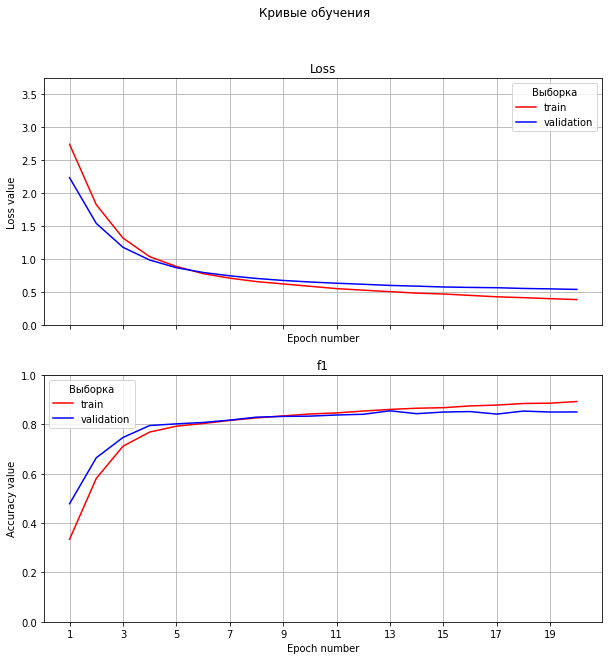

In [175]:
plot_curves()

## Формирование меток для теста

In [81]:
test_dset = EventDetectionDataset(x_test, device=device)
test_loader = DataLoader(test_dset, batch_size=1, shuffle=False, num_workers=num_workers)

In [82]:
id_to_label = [label for label, i in label_to_id.items()]

In [86]:
results_lable = []
with torch.no_grad():
        for i_batch, sample_batched in enumerate(tqdm(test_loader, position=0, leave=True)):
            x = sample_batched
            #optimizer.zero_grad()
            output = AST_model(x)
            
            predicted_class_idx = output.logits.argmax(-1).item()
            results_lable.append(AST_model.config.id2label[predicted_class_idx])

100%|██████████| 3790/3790 [04:26<00:00, 14.22it/s]


In [87]:
ans = pd.read_csv(test_csv)
for filename, label in zip(os.listdir(test_folder), results_lable):
    ans.loc[ans['fname']==filename, 'label'] = label

In [88]:
ans.to_csv('ast_results.csv',index=False)